# Script analyzing the robustness of selection of H3 level
## Cluster overlap analysis
Compare the data points assigned to cluster 5 in 
𝐶
6
C 
6
​
  with those assigned to each cluster in 
𝐶
5
C 
5
​
 . The cluster in 
𝐶
5
C 
5
​
  that shares the most data points with cluster 5 in 
𝐶
6
C 
6
​
  is likely the most similar.

Steps:
Assign labels to each data point from both clusterings.
Compute the intersection (or overlap) of cluster 5 from 
𝐶
6
C 
6
​
  with each cluster in 
𝐶
5
C 
5
​
 .
Identify the cluster in 
𝐶
5
C 
5
​
  with the highest overlap.

In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
import gspread
import h3
from tqdm import tqdm
# from fcmeans import FCM
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import NMF
from sklearn.metrics import silhouette_score, silhouette_samples
import seaborn as sns
# import kmean
from sklearn.cluster import KMeans
from scipy.spatial import distance
import os


In [2]:

ROOTFOLDER = r"D:\Dropbox (Personal)\Personal Work\_Projects2023\01_city-never-was"
DATA_FOLDER = f"{ROOTFOLDER}/_data/_curated/c_seg_hex"
GRAPH_FOLDER = f"{ROOTFOLDER}/_graphic/_supplemental/_raw"
# os.listdir(DATA_FOLDER)
filename = 'c_seg_cat=27_res=9_withincity_built_environment_tsne_cluster_range.csv'
df = pd.read_csv(f"{DATA_FOLDER}/{filename}")
df.head()

,city_lower,hex_id,img_count,bike,building,bus,car,grass,installation,lake+waterboday,...,trashcan,tree,truck,van,window,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,accra,8975292c127ffff,20,28.700000,17571.900000,25.100000,4789.850000,213.300000,269.500000,0.000000,...,22.850000,5621.900000,2563.850000,1130.700000,0.0,3,3,0,0,3
1,accra,8975292c803ffff,40,0.000000,13691.775000,0.000000,53.250000,126.950000,53.625000,0.000000,...,5.700000,1641.025000,2.100000,0.000000,0.0,0,0,4,6,0
2,accra,8975292c80bffff,80,5.912500,15249.062500,0.000000,408.512500,247.675000,53.212500,755.137500,...,0.000000,2151.100000,0.000000,1.550000,0.0,3,3,0,0,5
3,accra,8975292c817ffff,56,2.196429,11558.571429,43.410714,750.678571,621.946429,0.571429,620.642857,...,0.285714,8563.303571,16.535714,8.071429,0.0,3,3,0,0,5
4,accra,8975292c81bffff,32,0.000000,12744.843750,0.000000,236.343750,0.031250,461.625000,1.781250,...,0.937500,2864.250000,0.000000,0.000000,0.0,3,3,0,0,5


In [3]:
cluster_name_7 = {
    0: 'Open-view Arterials',
    1: 'High-rise Community',
    2: 'Scenic View-a',
    3: 'Suburban Fringe',
    4: 'Dense Road Core',
    5: 'Low-rise Community',
    6: 'Scenic View-b'
}
cluster_color = {
    'Open-view Arterials':'#da70bf',
    'High-rise Community':'#ddb27c',
    'Scenic View-a':'#ff991f',
    'Scenic View-b':'#ff991f',
    'Suburban Fringe':'#f15c17',
    'Dense Road Core':'#12939a',
    'Low-rise Community':"#223f9a"
}

# find the cluster mapping between cluster_x and cluster_7
def map_cluster_7(x):
    cluster_summary = df.groupby([f'cluster_{x}','cluster_7',]).size().unstack().fillna(0)
# map the cluster_4 to cluster_x by picking the most frequent cluster_7
    cluster_7_mapping = cluster_summary.idxmax(axis=1).to_dict()
    cluster_7_mapping_naming = {k:cluster_name_7[v] for k,v in cluster_7_mapping.items()}
    return cluster_summary, cluster_7_mapping, cluster_7_mapping_naming

In [4]:
mapping_dict_all = {}
mapping_name_dict_all = {}
summary_df = []
for i in range(4, 9):
    if i!=7:
        cluster_summary, mapping_dict_all[f'cluster_{i}'], mapping_name_dict_all[f'cluster_{i}'] = map_cluster_7(i)
        cluster_summary = cluster_summary.reset_index().rename(columns={f'cluster_{i}':"cluster_original"})
        cluster_summary['k'] = i
        summary_df.append(cluster_summary)
summary_df = pd.concat(summary_df).reset_index(drop=True).rename(columns=cluster_name_7)
mapping_dict_all

{'cluster_4': {0: 2, 1: 4, 2: 5, 3: 0},
 'cluster_5': {0: 6, 1: 2, 2: 4, 3: 0, 4: 5},
 'cluster_6': {0: 0, 1: 3, 2: 4, 3: 5, 4: 6, 5: 2},
 'cluster_8': {0: 2, 1: 3, 2: 5, 3: 0, 4: 1, 5: 6, 6: 2, 7: 4}}

C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_30212\3016931899.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(['{:,.0%}'.format(x) for x in axes[i].get_xticks()])
C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_30212\3016931899.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(['{:,.0%}'.format(x) for x in axes[i].get_xticks()])
C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_30212\3016931899.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(['{:,.0%}'.format(x) for x in axes[i].get_xticks()])
C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_30212\3016931899.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(['{:,.0%}'.format(x) for x in axes[i].get_xticks()])


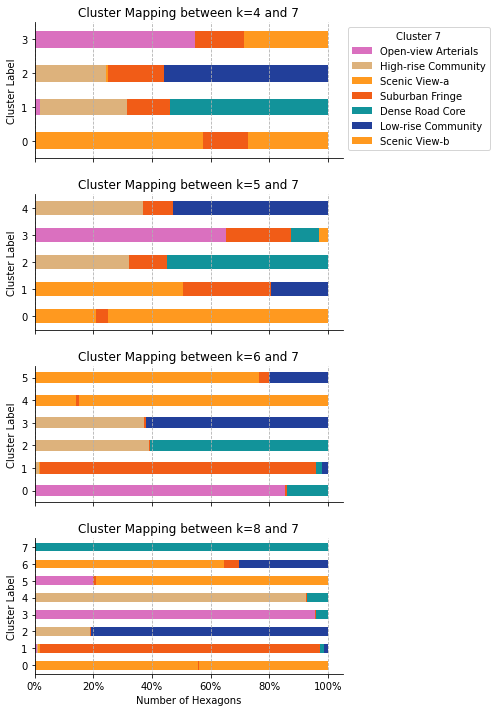

In [5]:
# plot a stacked barplot
fig, axes = plt.subplots(4,1, figsize=(7,10), sharex=True)

# summary_df.set_index(['k','cluster_original']).plot(
#     kind='bar', stacked=True, figsize=(10, 6), title='Cluster Mapping between Different Cluster Numbers')
for i, k in enumerate([4,5,6,8]):
    if k==7:
        continue
    # create horizontal stacked barplot for each k
    # convert to percentage for better comparison
    df_temp = summary_df[summary_df.k==k].set_index('cluster_original').drop(columns='k')
    df_temp = df_temp.div(df_temp.sum(axis=1), axis=0)
    
    df_temp.plot(kind='barh', stacked=True,  ax=axes[i], color = [cluster_color[x] for x in df_temp.columns])
    axes[i].set_xlabel('Number of Hexagons')
    axes[i].set_ylabel('Cluster Label')
    axes[i].set_title(f'Cluster Mapping between k={k} and 7')
    # share one legend for all subplots
    if i==0:
        axes[i].legend(title='Cluster 7', bbox_to_anchor=(1, 1))
    else:
        axes[i].legend().remove()
        
    # make x-axis percentage
    axes[i].set_xticklabels(['{:,.0%}'.format(x) for x in axes[i].get_xticks()])
    # hide the top and right spines
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    # show major grids
    axes[i].grid(axis='x', linestyle='--')
plt.tight_layout()
fig.savefig(f"{GRAPH_FOLDER}/cluster_mapping.png", dpi=200, bbox_inches='tight')

## aggregate the data to city level and merge back to the source

In [6]:
df_city_all = []
for k in [4,5,6,8]:
    df_city = df.groupby(['city_lower',f'cluster_{k}'])['hex_id'].nunique().unstack().fillna(0)\
        .div(df.groupby('city_lower')['hex_id'].nunique(), axis=0).reset_index()
    if k ==8:
        df_city[6] = df_city[0]+df_city[6]
        df_city.drop(columns=0, inplace=True)
    df_city.rename(columns=mapping_name_dict_all[f'cluster_{k}'], inplace=True)
    # if their column names are the same, then we can merge them by adding the percentage
    
    # get percentage

    df_city['k'] = k
    
    df_city_all.append(df_city)
df_city_all = pd.concat(df_city_all)
df_city_all['robustness_type'] = 'k-means'
df_city_all.to_csv(f"{DATA_FOLDER}/robustness_city_cluster_mapping.csv", index=False)

# load all and merge again

In [7]:
df_city_all = pd.read_csv(f"{DATA_FOLDER}/robustness_city_cluster_mapping.csv")
df_city_h3_8 = pd.read_csv(os.path.join(DATA_FOLDER, 'robustness_h3_8.csv'))
#load other variables
otherdf = pd.read_csv(os.path.join(f"{ROOTFOLDER}/_data/_curated/c_analysis","c_city_built_environment_full_cluster=7_ncat=27.csv"))

df_long = pd.concat([df_city_all, df_city_h3_8], sort=False)
otherdf_merge = otherdf.merge(df_long, on=['city_lower'], how='left')

In [8]:
otherdf_merge.to_csv(os.path.join(f"{ROOTFOLDER}/_data/_curated/c_analysis",
                                  "c_city_built_environment_full_cluster=all_ncat=27.csv"), index=False)

for